Choose GPU

In [1]:
import os
KAGGLE = True
if os.name == "nt":
    KAGGLE = False
print(f"KAGGLE: {KAGGLE}")
if not KAGGLE:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

KAGGLE: False


In [44]:
# general
import gc
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from glob import glob
import random
import numpy as np
import pandas as pd
import json
from IPython.core.display import display, HTML
if KAGGLE:
    from kaggle_datasets import KaggleDatasets

# ML
from sklearn.metrics import roc_auc_score

# DL
import tensorflow as tf
tf.config.optimizer.set_jit(True)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



### Settings

In [3]:
# tf.compat.v1.disable_eager_execution()
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [4]:
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        print(f"Running on TPU: {tpu.master()}")
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
    num_replicas = strategy.num_replicas_in_sync
    print(f"Running on {num_replicas} replica{'s' if num_replicas > 1 else ''}")
    return strategy, TPU_DETECTED, num_replicas

## PARAMS

In [5]:
strategy, TPU_Detected, REPLICAS = auto_select_accelerator()
INPUT_DIR = "../input/g2net-gravitational-wave-detection"
MDLS_PATH = "." if KAGGLE else "../models"
# TRAIN_FILES_PATH = "../input/filtered*_tfrec"
AUTO = tf.data.experimental.AUTOTUNE
tfrec_folders = ["filtered-tfrec", "filtered-whitened-tfrec", "filtered-whitened-inverted-tfrec", "whitened-tfrec"]


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Running on 1 replica


In [6]:
# if not KAGGLE:
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    results_df = pd.DataFrame()
else:
    results_df = pd.read_csv("../models/results.csv", index_col=[0]).tail(20)
results_df

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
21,0.00100,72,full,256,10,9,0.483452,0.824098,took out the fully connected layers before the...,42.0
22,0.00100,73,full,256,10,9,0.472798,0.830427,added back one fully connected layer,42.0
23,0.00010,75,full,256,10,9,0.454001,0.830381,"doubled pool size, except for last, doubled nu...",42.0
24,0.00100,76,full,256,10,6,0.469206,0.832270,base model with same padding,42.0
25,0.00010,78,full,256,40,12,0.442443,0.841306,doubled last layer in all blocks. lr/10,42.0
26,0.00050,79,full,256,40,25,0.439258,0.842578,doubled last layer in all blocks doubled size ...,42.0
27,0.00050,83,full,256,40,27,0.439051,0.841536,added dropout layers to dense layers,42.0
28,0.00010,88,full,256,40,8,0.453092,0.834111,everything had 3 layers now and relu activation,42.0
29,0.00010,92,full,256,100,17,0.434836,0.832301,dropout layers,42.0
30,0.00010,110,full,256,100,11,0.470093,0.815836,dropout layers,42.0


In [7]:
if KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

In [8]:
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    VER = 1
else:
    results = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=[0])
    VER = int(results.version.max())
Params ={
    "lr": 0.0001 * REPLICAS,
    "version": VER,
    "train_mode": "full", #test, full
    "batch_size": 128 * REPLICAS,
    "epochs":5,
    "seed": 42,
    "changelog": "1/4 lr",
}
seed_everything(Params["seed"])

Make Model directory

In [9]:
VER = Params["version"]
MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
while os.path.exists(MDL_PATH):
    VER += 1
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
Params["version"]=VER
os.mkdir(MDL_PATH)

In [10]:
def load_dataset(files, shuffle=True, ordered=False, labeled = True, repeat=True, return_labels = False):
    if ordered:
        dataset = tf.data.TFRecordDataset(files, num_parallel_reads=None)
    else:
        dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)


    def _parse_function(example_proto):
        if labeled:
            keys_to_feature = {
                "TimeSeries":tf.io.FixedLenFeature([4096,3],tf.float32),
                "Target":tf.io.FixedLenFeature([], tf.int64, default_value=0)}
            if return_labels:
                keys_to_feature["id"]=tf.io.FixedLenFeature([],tf.string, default_value="")
        else:
            keys_to_feature = {
                "TimeSeries": tf.io.FixedLenFeature([4096,3],tf.float32)
            }
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        if labeled:
            if return_labels:
                return parsed_features["TimeSeries"], parsed_features["Target"], parsed_features["id"]
            else:
                return parsed_features["TimeSeries"], parsed_features["Target"]
        else:
            return parsed_features["TimeSeries"]
    
    if not ordered:
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic=False
        dataset = dataset.with_options(ignore_order)
    # parse the record into tensors.
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTO)
    dataset = dataset.cache()

    # shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    # Repeat the input infinitely
    if repeat:
        dataset = dataset.repeat()


    # Generate batches
    dataset = dataset.batch(Params["batch_size"])
    dataset = dataset.prefetch(-1)
    return dataset

In [38]:
def get_train_val_files(folders):
    train_files = []
    val_files = []
    test_files = []
    all_train_files = []
    for folder in folders:
        if KAGGLE:
            TRAIN_FILES_PATH = KaggleDatasets().get_gcs_path(folder)
            all_files_train = np.sort(tf.io.gfile.glob(f"{TRAIN_FILES_PATH}/train_*.tfrec"))
            all_files_test = np.sort(tf.io.gfile.glob(f"{TRAIN_FILES_PATH}/test_*.tfrec"))
        else:
            all_files_train = np.sort(glob(f"../input/{folder}/train_*.tfrec"))
            all_files_test = np.sort(glob(f"../input/{folder}/test_*.tfrec"))
        train_files.extend(all_files_train[:-2])
        val_files.extend(all_files_train[-2:])
        test_files.append(all_files_test)
        all_train_files.append(all_files_train)
    return train_files, val_files, test_files, all_train_files

train_files, val_files, test_files, all_train_files = get_train_val_files(tfrec_folders)


In [ ]:
train_ds = load_dataset(train_files)
val_ds = load_dataset(val_files)

In [12]:
from tensorflow.keras import Sequential, layers
with strategy.scope():
    model = Sequential([
        layers.Conv1D(filters=32, kernel_size=16, padding="causal",input_shape=[4096,3]),
        layers.Conv1D(filters=32, kernel_size=16, padding="causal",input_shape=[4096,3]),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=64, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Dropout(0.4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=256, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=256, kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1),
        layers.Activation("sigmoid", dtype="float32")
    ])
    model.compile(
        tf.keras.optimizers.Adam(learning_rate = Params["lr"]),
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4096, 32)          1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4096, 32)          16416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1024, 32)          0         
_________________________________________________________________
activation (Activation)      (None, 1024, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1024, 64)          16448     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 128)         65664     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1024, 128)         1

In [13]:
steps_per_epoch = 560000 // 16 * len(train_files) // Params["batch_size"]
validation_steps = 560000 // 16 * len(val_files) // Params["batch_size"]

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2,
    patience=3, min_lr = 0.000001,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{MDL_PATH}/model_{Params['version']:03}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weight_only=False,
    mode="auto",
    save_freq="epoch"
)

callbacks=[reduce_lr, early_stop, model_checkpoint]

In [15]:
history = model.fit(train_ds, validation_data = val_ds, epochs = Params["epochs"], shuffle=True,
                    steps_per_epoch = steps_per_epoch, validation_steps=validation_steps,
                    verbose=1, callbacks=callbacks)

Epoch 1/5


11160/15312 [====================>.........] - ETA: 4:26 - loss: 0.5046 - auc: 0.8023

13418/15312 [=========================>....] - ETA: 2:35 - loss: 0.4979 - auc: 0.8077- ETA: 4:26 - loss: 0.5046 - auc: 0.802 - ETA: 4:26 - loss: 0.5046 - auc: - ETA: 4:26 - loss: 0.5046 - auc:  - ETA: 4: - ETA: 4:25 - loss: 0.5045 - auc:  - ETA: 4:25 - loss: 0.5045 - auc: 0.802 - ETA: 4:25  - ETA: 4:24 - loss: 0.5044 - auc: - ETA: 4:23 - loss: 0.5044 - auc: 0. - ETA: 4:23 - loss: 0.5044 - auc: 0.8 - ETA: 4:23 - loss: 0.5043 - auc: 0.802 - ETA: 4:23 - loss: 0.5043 - auc: 0.80 - ETA: 4:23 - loss:  - ETA: 4:22 - loss: 0.5043 - auc: 0.80 - ETA: 4:22 - loss:  - ETA: 4:22 - loss: 0.5 - ETA: 4:21 - loss: 0.5042 - auc: 0.8 - ETA: 4:21 - loss: 0.5042 - a - ETA: 4:21 - loss: 0.5041 - auc: 0.80 - ETA: 4:20 - loss: 0.5041 - auc: 0.802 - ETA: 4:20 - loss: 0.5041 - auc: 0.802 - ETA: 4:20 - loss: 0.5041 - ETA: 4:20 - loss: 0.5040 - auc: 0.802 - ETA: 4:20 - loss: 0.5041 - auc: 0.802 - ETA: 4:20 - loss: 0.504 - ETA: 4:19 - loss: 0.504 - ETA: 4:19 - loss: 0.5040 -  - ETA: 4:18 - loss: 0.5039 - auc: 0.80

15312/15312 [==============================] - 1887s 123ms/step - loss: 0.4932 - auc: 0.8114 - val_loss: 0.4742 - val_auc: 0.8300A: 2:34 - loss: 0.4978 -  - ETA: 2:33 - loss: 0.4978 - auc: - ETA: 2:33 - loss: 0.4978 - auc: 0.807 - ETA: 2:33 - loss: 0.4978 - auc: 0.8 - ETA: 2:32 - loss: 0.4978 - auc: 0.807 - ETA: 2:32 - loss: 0.4978 - auc: 0.80 - ETA: 2:32 - loss: 0. - ETA: 2:31 - loss: 0.4977 - auc: 0.807 - ETA: 2:31 - loss: 0.49 - ETA: 2:30 - loss: 0.4977  - ETA: 2:29 - loss: 0.4976  - ETA: 2:28 - loss: 0.4976 - auc: 0.8 - ETA: 2:28 - loss: 0.4 - ETA: 2:27 - loss: 0. - ETA: 2:26 - loss: 0.4975 - - ETA: 2:25 - loss: 0.4975 - auc: 0.8 - ETA: 2:24 - loss: 0.4975 - auc - ETA: 2:24 - loss: 0.4975 - auc: 0.8 - ETA: 2:24 - loss: 0.4974 - auc: 0.808 - ETA: 2:24 - loss: 0.4974 - auc - ETA: 2:23 - loss: 0. - ETA: 2:22 - loss: 0.4974 - auc: 0.808 - ETA: 2:22 - loss: 0.4974 - auc: 0.8 - ETA: 2:22 - loss:  - ETA: 2:17 - loss: 0.4972 - au - ETA: 2:17 - loss: 0.4972 - auc: 0 - ETA: 2:16 - loss: 0.4 

15312/15312 [==============================] - 1444s 94ms/step - loss: 0.4637 - auc: 0.8322 - val_loss: 0.4608 - val_auc: 0.832811:37 - loss: 0.4984 - auc: 0.80 - ETA: 11:38 -  - ETA: 11:24 - lo - E - ETA: 11:26 - loss:  - ETA: 11:2 - ETA: 11:29 - loss: 0.4937 - auc:  - ETA: 11:27 - loss: 0.4939 - - ETA: 11:24 - loss: 0.4937 - a - ETA: 11:25 - loss: 0.4940 - auc: 0.80 - ETA: 11:24 - loss - ETA: 11:26 - loss: 0.49 - ETA: 11:24 - loss: 0.4935 - auc - ETA: 11:22 -  - ETA: 11:18 - loss - ETA: 11:17 - loss: 0.4943 - - E - ETA: 11:18 - lo - ETA: 11:19 - loss: 0.49 - ETA: 11:17 - loss: 0.4931 - ETA: 11:15 - loss: 0. - ETA: 11:14 -  - ETA: 11:13 - loss: 0.4934 - auc: 0.80 - ETA: 11:13 - loss: 0.4935 - auc: 0. - ETA: 11:14 - loss: 0.4936 - ETA: 11:15 - loss: 0.4936 - a - ETA: 11:15 - loss: 0.4933 - auc: 0. - ETA: 11:14  - ETA: 11:15  - ETA: 11:14 - loss: 0.4930 - auc: 0.80 - ETA - ETA: 11:14 - loss: 0.4929 - ETA: 11:14 - loss: 0. - ETA: 11:10 - loss: 0.4927 - auc: 0.80 - ETA - ETA: 11:08 - loss

 5679/15312 [==========>...................] - ETA: 6:42 - loss: 0.4729 - auc: 0.8242  ETA: 12:40 - loss:  - ETA: 12:50 - loss: 0.49 - ETA: 13:26 - loss: 0.4907 - a - ETA: 13:22 - loss: 0.48 - ETA: 12:57  - ETA: 13:01 - loss - ETA: 13:03 - loss: 0.48 - ETA: 12:54 - loss: 0.4888 - auc - ETA: 12:54 - loss: 0.4884 - auc: 0. - ETA: 12:51 - loss: 0.4885 - auc:  - ETA: 12:48 - loss: 0.4880 - auc:  - ETA: 12:47 - loss: 0.4879 - - ETA: 12:27 - loss: 0.4867 - ETA: 12:18 - loss: 0.4865 - auc - ETA: 12:1 - ETA: 12:07 - loss: 0.4851 - auc: 0.81 - ETA: 12:05  - ETA: 11:59 - loss: 0.4848 - auc:  - ETA: 11:59 - lo - ETA: 11:50 - loss: 0.4858 - E - ETA: 11:40 - loss: 0.4862 - auc: 0. - ETA: 11:41 - loss: 0.4865 - - ETA: 11:31 - loss: 0.4850 - auc - ETA: 11:30 -  - ETA: 11:21 - loss: 0. - ETA: 11:07 - loss: 0.4854 - a - ETA:  - ETA: 11:07 - loss: 0.4853 - ETA - ETA: 11:00 - loss:  - ETA: 11:00 - loss: 0.4855 - auc: 0. - ETA: 10:59 - loss: 0.4855 - - ETA: 10:57  - ETA: 10:57 -  - ETA: 10:54 - loss: 0.48

11354/15312 [=====================>........] - ETA: 2:40 - loss: 0.4616 - auc: 0.8334- ETA: 6:41 - loss: 0.4729 - auc: 0.82 - ETA: 6:41 - loss: 0.4729 - auc: 0.824 - ETA: 6:41 - loss: 0.4729 - auc - ETA: 6:41 - loss: 0.4728 - auc: 0.8 - ETA: 6:40 - loss: 0.4728 - auc - ETA: 6:40 - loss: 0.472 - ETA:  - ETA: 6:37 - loss: 0.4726 - ETA: 6:35 - loss:  - ETA: 6:34 - loss: 0.4725 - auc: 0.8 - ETA: 6:34 - loss: 0.4724 - auc: 0. - ETA: 6:33 - loss: 0.4724 - auc: - ETA: 6:33 - loss: 0.4724 - auc: 0.82 - ETA: 6:33 - loss: 0.4724  - ETA: 6:32 - loss: 0.4723 - au - ETA: 6:31 - loss: 0.4722 -  - ETA: 6:30 - loss: 0.472 - ETA: 6:2 - ETA: 6:20 - loss: 0.4715 - auc: 0.825 - ETA: 6:20 - loss: 0.4715 - auc: 0 - ETA: 6:20 - loss: 0.4715 - auc:  - ETA: 6:19 - loss: 0.471 - ETA: 6:18 - loss: 0.4714 - auc: 0. - ETA: 6:17 - los - ETA: 6:16 - loss: 0.4712 - auc: 0.825 - ETA: 6:16 - loss: 0.4712 - auc: 0.82 - ETA: 6:16 - loss: 0.4712 - auc: - ETA: 6:15 - loss: 0.4712 - auc:  - ETA: 6: - ETA: 6:13 - loss: 0.471

15312/15312 [==============================] - 631s 41ms/step - loss: 0.4572 - auc: 0.8369 - val_loss: 0.4582 - val_auc: 0.83372:40 - loss:  - ETA: 2:38 - loss: 0.4616 -  - ETA: 2:38 - loss: 0.461 - ETA: 2:37 - l - ETA: 2:35 - lo - ETA: 2:33 - loss: 0.4614  - ETA: 2:33 - loss: 0.4614  - ETA: 2:32 - loss: 0.4614 - auc:  - ETA: 2:31 - loss: 0.4613 - - ETA: 2:30 - lo - ETA: 2 - ETA: 2:26 - loss: 0.4612 - auc: 0.83 - ETA: 2:26 - loss: 0.46 - ETA: 2:25 - loss:  - ETA: 2:24 - loss: 0.4612 - auc: 0.833 - ETA: 2:24 - loss: 0.4612 - auc: 0. - ETA: 2:23 - loss: 0.4612 - auc: 0.8 - ETA: 2:23 - loss: 0.4612 - auc:  - ETA: 2:23 - loss: 0.4 - ETA: 2:22 - loss: 0.4612 - auc: 0.8 - ETA: 2:22 - loss: 0.4612 - au - ETA: 2:21 - loss: 0.4612 - auc: - ETA: 2:21 - loss: 0.4612 - auc: - ETA: 2:20 - loss: 0.4612 - au - ETA: 2:19 - loss: 0.4611  - ETA: 2:19  - ETA: 2:17 - loss: 0.4610 - auc: - ETA: 2:17 - loss: 0.4610 - auc: 0. - ETA: 2:17 - loss: 0.461 - ETA: 2:16 - loss: 0. - ETA: 2:14 - loss: 0.4610 -  - ET

 5769/15312 [==========>...................] - ETA: 6:15 - loss: 0.4675 - auc: 0.8282  ETA: 10:55 - loss: 0.4947 - ETA: 11:16 - loss: 0. - ETA: 10:41 - loss:  - ETA: 10:31 - loss: 0.49 - ETA: 10:27 - loss: 0.4903 - a - ETA: 10:23 - loss: 0.4893 - auc:  - ETA: 10:27 - loss: 0.4888 - auc:  - ETA: 10:22 - loss: 0.48 - ETA: 10:21 - loss: - ETA: 10:00 - loss: 0.4846 - auc: 0. - ETA: 10:02 - loss: 0.4846 - auc: 0. - ETA: 10:02 - loss: 0.484 - ETA: 9:57 - - ETA: 9:50 - loss: 0.4810 - auc: - ETA: 9:53 - loss: 0.4809 - auc: 0. - ETA: 9:53 - loss: 0.4809 - ETA: 9:56 - loss: 0.4804 - auc: 0.81 - ETA: 9:55 - loss: 0.4807 - auc: 0. - ETA: 9:57 - loss: 0.4802 - auc: 0.81 - ETA: 9:57 - loss: 0.4805 - au - ETA: 9:59 - loss: 0.4808 - auc: 0.817 - ETA: 9:59 - loss: 0.480 - ETA: 9:58 - loss - ETA: 9:57 - loss: 0.4814 - auc: 0. - ETA: 9:57 - loss: 0.4810 - auc: - ETA: 9 - ETA: 9:54 - loss: 0.4819 - auc - ETA: 9:58 - loss: 0.4818 - ETA: 9:55 - loss: 0.4818  - ETA: 9:57 - loss: 0.4818 - auc: 0.816 - ETA: 9:

10629/15312 [===================>..........] - ETA: 3:05 - loss: 0.4569 - auc: 0.8367- ETA: 6:15 - loss: 0.4674 - a - ETA: 6:14 - loss: 0.4674 - auc: - ETA: 6:13 - loss: 0.4673 - - ETA: 6:13 -  - ETA: 6:11 - loss: 0.4672 - auc: 0.82 - ETA: 6:11 - loss: 0 - ETA: 6:10 - loss: 0.4671 - auc:  - ETA: 6:09 - los - ETA: 6:08 - loss: 0.4669 - a - ETA: 6:07 - loss: 0.4669 - ETA: 6:07 - loss: 0 - ETA: 6:06 - loss: 0.4667 - auc:  - ET - ETA: 6:02 - loss: 0.4665 - au - ETA: 6:02 - loss: 0.4665 - auc: 0. - ETA: 6:01 - loss: 0.4665 - auc: 0.82 - ETA: 6 - ETA: 5:59 - loss: 0.4663  - ETA: 5:59 - loss: 0.4663 - auc: 0. - ETA: 5:58 - loss:  - ETA: 5:57 - loss: 0.46 - ETA: 5: - ETA: 5:54 - loss: 0.4659 - auc: 0.8 - ETA: 5:54 - lo - ETA: 5:53 - loss: 0.4658 - auc: 0 - ETA: 5:52 - loss: 0.4658 - auc: - ETA: 5:52 - loss: 0.4657 - auc: - ETA: 5:52 - loss: 0.4657 - auc - ETA: 5:51 - loss:  - ETA: 5:50 - loss: 0.4655 - - ETA: 5:50 - loss: 0.4655 - auc: 0. - ETA: 5:49 - loss: 0.4655 - au - ETA: 5:49 - loss: 0.4

15312/15312 [==============================] - 623s 41ms/step - loss: 0.4518 - auc: 0.8406 - val_loss: 0.4568 - val_auc: 0.8364 - ETA: 3:02 - loss - ETA:  - ETA: 2:59 - loss: 0.4567  - ETA: 2:58 - loss: - ETA: 2:57 - loss: 0.4567 - auc - ETA: 2:56 - loss: 0.4567 - auc: 0.836 - ETA: 2:56 - loss: 0.4567 - auc - ETA: 2:56 - loss: 0.4567 - au - ETA: 2:55 - loss: 0.4567 - au  - ET - ETA: 2:50 - loss: 0.4565 - auc: 0 - ETA: 2:49 - loss: 0.4565 - auc:  - ETA: 2:49 - loss: 0.4565 - auc: 0. - ETA: 2:49 - loss: 0.4565 - auc: 0.8 - ETA: 2:49 - loss: 0.4565 - auc: 0.8 - ETA: 2:48 - loss: 0.4565 - auc: 0.837 - ETA: 2:48 - loss: - ETA: 2:47 - loss: 0.4564 - auc: 0.8 - ETA: 2:47 - loss: 0.4564 - auc: 0. - ETA:   - ETA: 2:39 - loss: 0.4563 -  - ETA: 2:39 - loss: 0.4563 - auc: 0. - ETA: 2:38 - loss: 0.4563  - ETA: 2:38 - loss: 0.4563  - ETA: 2:37 - loss: 0.4563 - auc - ETA: 2:36 - loss: 0.4563 - auc: 0.83 - ETA: 2:36 - loss: 0.4563 - auc: 0.837 - ETA: 2:36 - loss: 0.4 - ETA: 2:35 - los - ETA: 2:28 - lo

 5838/15312 [==========>...................] - ETA: 6:17 - loss: 0.4634 - auc: 0.8316  ETA: 10:21 - loss: 0.49 - ETA - ETA: 9:50 - loss: 0.4920 - auc:  - ETA: 9:46 - loss: 0.4923 - auc: 0 - ETA: 9:52 - loss: 0.4919 - auc: 0.81 - ETA: 9:54 - l - ETA: 9:40 - lo - ETA: 9:27 - loss: 0 - ETA: 9:23 - loss: 0.4841 - auc: 0.8 - ETA: 9:21 - loss: 0.4839 - au - ETA: 9:24 - loss: 0.4826 - auc: - ETA: 9:25 - loss: 0.4816 - auc: 0.818 - ETA: 9:25 - loss: 0.4815 - auc: 0 - ETA: 9:25 - loss: 0.4810 - a - ETA: 9:24 - loss: 0.4803 -  - ETA: 9:24 - loss: 0.4793 - a - ETA: 9:27 - loss: 0.4785 - auc:  - ETA: 9:25 - loss: 0.4787 - auc:  - ETA: 9:24 - loss: 0.4785 - ETA: 9:25 - loss: 0.4781 - auc: - ETA: 9:28 - loss: 0.4781   - ETA: 9:26 - loss: 0.4782 - auc:  - ETA: 9:29 - loss: 0.4781 - auc - ETA: 9:30 - loss: 0.4787 - auc: 0.818 - ETA: 9:29 - loss: 0.4786 -  - ETA: 9:29 - loss: 0.4785 - au - ETA: 9:2 - ETA: 9:29 - loss: 0.4786 - a - ETA: 9:29 - loss: 0.4788 - a - ETA: 9: - ETA: 9:35 - loss: 0.4789 - auc:

11891/15312 [======================>.......] - ETA: 2:15 - loss: 0.4517 - auc: 0.8408- ETA: 6:15 - loss: 0.4633 - auc: 0. - ETA: 6:15 - loss: 0.4633 - auc: 0. - ETA: 6:15 - loss: 0.4632 - auc: - ETA: 6:14 - loss: 0.4632 - auc:  - ETA: 6:14 - loss: 0.4631 -  - ETA: 6:14 - loss: 0.4630 - auc: 0. - ETA: 6:13 - loss: 0.4630 - auc: 0.832 - ETA: 6:13 - loss: 0.4630 - auc: 0 - ETA: 6:13 - loss: 0.4630 - auc: 0. - ETA: 6:13 - loss: 0.4629 - auc: 0.8 - ETA: 6:13 - loss: 0.4629 - auc: - ETA: 6 - ETA: 6:10 - loss: 0.4627 - auc: 0. - ETA: 6:10 - loss: 0.4627 -  - ETA: 6:10 - loss: 0.4627 - auc - ETA: 6:09 - loss: 0.4 - ETA: 6:08 - loss: 0.46 - ETA: 6:07 - lo - ETA: 6:05 - loss: 0.4624 - auc: 0.8 - ETA: 6:05 - ETA: 6:03 - loss: 0.4622 - auc: 0.83 - ETA: 6:03 - loss: 0.4622 - auc: 0.83 - ETA: 6:03 - loss: 0. - ETA: 6:01 - l - ETA: 6:00 - loss: 0.462 - ETA: 5:59 - loss: 0.4 - ETA: 5:57 - loss:  - ETA: 5:51 - loss: 0.4611 - - ETA: 5 - ETA: 5:47 - loss: 0.4608 - auc: 0.8 - ETA: 5:47 - loss - ETA: 5:46 

15312/15312 [==============================] - 621s 41ms/step - loss: 0.4477 - auc: 0.8438 - val_loss: 0.4544 - val_auc: 0.8370TA: 2:15 - loss: 0.4517 - auc: 0.8 - ETA: 2:14 - loss: 0.4516 - auc - ETA: 2:14 - loss: 0.4516 - auc: 0.840 - ETA: 2:14 - loss: 0.4516 - auc: 0.84 - ETA: 2:14 - loss: 0.4516 - auc: 0.8 - ETA: 2:14 - loss: 0.4516 - auc: 0.84 - ETA: 2:14 - loss: 0.4516 - a - ETA: 2:13 - loss: 0.45 - ETA: 2:12 - loss: 0.4516 - auc: 0.84 - ETA: 2:12 - loss: 0.4516 - auc: 0.84 - ETA: 2:12 - loss: 0.4516 - auc: 0.840 - ETA: 2:12 - loss: 0.4516 - a - ETA: 2:11 - loss: 0.4516  - ETA: 2:10 - loss: 0.4516  - ETA: 2:09 - loss: 0.4515 - auc: 0. - ETA: 2:09 - loss: 0.4515 - auc: 0 - ETA: 2:09 - loss: 0.4515 - auc: - ETA: 2:08 - l - ETA: 2:01 - loss: 0.4513 - auc:  - ETA: 2:01 - loss: 0.4513 - a - ETA: 2:00 - loss: 0.4513 - auc:  - ETA: 2:00 - loss: 0.4513 - auc: 0.8 - ETA: 2:00 - loss: 0.4513 - a - ETA: 1:59 - loss: 0.4512 - a - ETA: 1:58 - loss: 0.4512 - - ETA: 1:58 - loss: 0 - ETA: 1:57 -

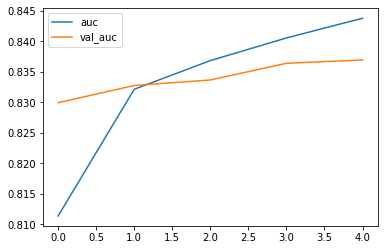

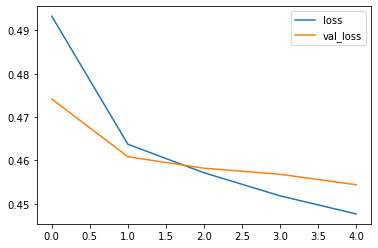

In [16]:
historyFrame = pd.DataFrame(history.history)
historyFrame[["auc", "val_auc"]].plot()
historyFrame[["loss", "val_loss"]].plot()
historyFrame.to_csv(f"{MDL_PATH}/history_mdl{Params['version']:03}.csv", index=False)

In [17]:
historyFrame

,loss,auc,val_loss,val_auc,lr
0,0.493235,0.811396,0.474165,0.829963,0.0001
1,0.463729,0.832171,0.460848,0.832787,0.0001
2,0.457160,0.836867,0.458215,0.833690,0.0001
3,0.451839,0.840582,0.456807,0.836425,0.0001
4,0.447673,0.843812,0.454397,0.836974,0.0001


In [18]:
best_epoch = historyFrame.val_auc.argmax()
best_loss = historyFrame.iloc[best_epoch].loss
best_auc = historyFrame.iloc[best_epoch].val_auc
print("best epoch:", best_epoch,
      "| best loss:", best_loss,
      "| best auc:", best_auc
     )

best epoch: 4 | best loss: 0.4476728141307831 | best auc: 0.8369743824005127


In [19]:
result = Params.copy()
result["bavg_epoch"] = int(best_epoch)
result["bavg_loss"] = float(best_loss)
result["bavg_auc"] = float(best_auc)
with open(f"{MDL_PATH}/params.json", "w") as file:
    json.dump(result, file)

if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    df_save = pd.DataFrame(result, index=[0])
    df_save.to_csv(f"{MDLS_PATH}/results.csv")
else:
    df_old = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=0)
    df_save = pd.DataFrame(result, index = [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index=True)
    df_save.to_csv(f"{MDLS_PATH}/results.csv")   

In [20]:
pd.read_csv(f"{MDLS_PATH}/results.csv",index_col=[0])

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
0,0.00100,1,full,256,60,16,0.451789,0.838065,NaN,NaN
1,0.00100,2,test,256,60,13,0.449180,0.822957,moved all relu layers before the pooling layers,NaN
2,0.00100,3,full,256,60,20,0.442866,0.837724,"tried on large ds, since hight overfitting",NaN
3,0.00100,5,test,256,60,13,0.449431,0.822973,added second layer to first block or reference,NaN
4,0.00100,6,test,256,30,9,0.442229,0.820143,added relu activations to all conv layers,NaN
5,0.00100,9,test,256,30,4,0.480765,0.812309,set all pool sizes to 1,NaN
6,0.00100,11,test,256,30,8,0.438630,0.819107,set all pool sizes to 8,NaN
7,0.00100,13,test,256,30,12,0.448575,0.820421,added second layer to first block with small k...,NaN
8,0.00010,14,test,256,30,12,0.457616,0.820876,added second layer to first block with small k...,NaN
9,0.00010,17,test,64,30,6,0.475783,0.814108,trial of completely different achitecture,NaN


In [27]:
del train_ds, val_ds
gc.collect()

NameError: name 'val_ds' is not defined

In [ ]:
prediction_scores = []
with strategy.scope():
    model = tf.keras.models.load_model(f"{MDL_PATH}/model_{Params['version']:03}.h5")
train_df = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
for ds_ind in range(len(all_train_files)):
    train_set = load_dataset(all_train_files[ds_ind], shuffle=False, ordered=True, labeled=True, repeat=False, return_labels=False)
    prediction = model.predict(train_set)
    tf.keras.backend.clear_session()
    gc.collect()
    prediction_scores.append(roc_auc_score(train_df.target, prediction))
print(prediction_scores)
best_pred = np.array(prediction_scores).argmax()

In [ ]:
test_set = load_dataset(test_files[best_pred], shuffle=False, ordered=True, labeled=False, repeat=False, return_labels=False)
test_prediction = model.predict(test_set)
sub = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
sub.target = test_prediction.flatten()
sub.to_csv(f"{MDL_PATH}/submission.csv", index=False)